In [1]:
import kagglehub
import os

path = kagglehub.dataset_download('rohitgrewal/airlines-flights-data')
print("Lokasi File Berada di Path berikut :", path)
print("Isi Path tersebut adalah", os.listdir(path))

100%|██████████| 2.33M/2.33M [00:00<00:00, 80.7MB/s]

Extracting files...


Lokasi File Berada di Path berikut : /root/.cache/kagglehub/datasets/rohitgrewal/airlines-flights-data/versions/1
Isi Path tersebut adalah ['airlines_flights_data.csv']


In [2]:
import pandas as pd

df = pd.read_csv(path + '/airlines_flights_data.csv')
df

,index,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...,...,...
300148,300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


In [3]:
df.drop(columns = 'index', inplace=True)
df.head(5)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


**PREPROCESSING**

In [4]:
Features = ['source_city','departure_time','stops','arrival_time','destination_city','class','days_left']

In [5]:
X = df[Features]
y = df['price']

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,  random_state=42
)

In [7]:
print(f"Jumlah data training {len(X_train)} dan jumlah data uji {len(X_test)}")

Jumlah data training 240122 dan jumlah data uji 60031


In [8]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

scaler = StandardScaler()
num_feat = ['days_left']
num_transform = scaler

In [9]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
cat_feat = ['source_city', 'departure_time','stops','arrival_time','destination_city']
cat_transform = encoder

In [10]:
ordinal_feat = ['class']
class_categ = ['Economy','Business']
ordinal_transform = OrdinalEncoder(categories=[class_categ])

In [11]:
from sklearn.preprocessing import FunctionTransformer
import numpy as np

log_transform = FunctionTransformer(np.log1p, inverse_func=np.expm1)

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('log',log_transform),
        ('scaler', num_transform)
    ]), num_feat),
    ('ord', ordinal_transform, ordinal_feat),
    ('cat', cat_transform, cat_feat)
], remainder = 'drop')

In [13]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00


In [14]:
from catboost import CatBoostRegressor, Pool

cbm = CatBoostRegressor(
    loss_function = 'RMSE',
    eval_metric = 'R2',
    random_seed = 42,
    early_stopping_rounds=50
)

In [15]:
from sklearn.compose import TransformedTargetRegressor

model_cat = TransformedTargetRegressor(
    regressor = cbm,
    func = np.log1p,
    inverse_func= np.expm1
)

In [16]:
cbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model_cat)
])

**HYPERPARAMETER TUNING**

In [17]:
params_dist = {
    'regressor__regressor__iterations' : [1500, 2000],
    'regressor__regressor__learning_rate' : [0.15, 0.2],
    'regressor__regressor__max_depth' : [10, 15, 20],
    'regressor__regressor__l2_leaf_reg': [7, 10, 15]

}

In [25]:
from sklearn.model_selection import RandomizedSearchCV

random_cbm = RandomizedSearchCV(
    estimator= cbm_pipeline,
    param_distributions= params_dist,
    cv = 2,
    n_iter =12,
    n_jobs = -1,
    random_state=42,
    scoring='r2',
    verbose=1
)

In [26]:
random_cbm.fit(X_train,y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
8 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line

0:	learn: 0.2520236	total: 50.1ms	remaining: 1m 15s
1:	learn: 0.4348322	total: 76.6ms	remaining: 57.4s
2:	learn: 0.5690407	total: 175ms	remaining: 1m 27s
3:	learn: 0.6663814	total: 243ms	remaining: 1m 30s
4:	learn: 0.7363394	total: 316ms	remaining: 1m 34s
5:	learn: 0.7871436	total: 374ms	remaining: 1m 33s
6:	learn: 0.8248081	total: 453ms	remaining: 1m 36s
7:	learn: 0.8524802	total: 544ms	remaining: 1m 41s
8:	learn: 0.8728468	total: 628ms	remaining: 1m 44s
9:	learn: 0.8880546	total: 706ms	remaining: 1m 45s
10:	learn: 0.8993804	total: 801ms	remaining: 1m 48s
11:	learn: 0.9079473	total: 895ms	remaining: 1m 51s
12:	learn: 0.9143519	total: 990ms	remaining: 1m 53s
13:	learn: 0.9191713	total: 1.09s	remaining: 1m 56s
14:	learn: 0.9229166	total: 1.19s	remaining: 1m 58s
15:	learn: 0.9257723	total: 1.29s	remaining: 2m
16:	learn: 0.9279403	total: 1.39s	remaining: 2m 1s
17:	learn: 0.9296299	total: 1.49s	remaining: 2m 2s
18:	learn: 0.9309902	total: 1.6s	remaining: 2m 4s
19:	learn: 0.9322607	total: 1

RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('log',
                                                                                                FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                                    inverse_func=<ufunc 'expm1'>)),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['days_left']),
                                                                              ('ord',
                                                                               OrdinalEncoder(categories=[['Economy',
                                                                                                           'Business']]),
                                                                               ['class']),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='...
                                                                         inverse_func=<ufunc 'expm1'>,
                                                                         regressor=<catboost.core.CatBoostRegressor object at 0x7fa1d398c740>))]),
                   n_iter=12, n_jobs=-1,
                   param_distributions={'regressor__regressor__iterations': [1500,
                                                                             2000],
                                        'regressor__regressor__l2_leaf_reg': [7,
                                                                              10,
                                                                              15],
                                        'regressor__regressor__learning_rate': [0.15,
                                                                                0.2],
                                        'regressor__regressor__max_depth': [10,
                                                                            15,
                                                                            20]},
                   random_state=42, scoring='r2', verbose=1)

In [27]:
best_cbm = random_cbm.best_estimator_

**EVALUATE MODEL**

In [28]:
print('Best Params yang ditemukan', random_cbm.best_params_)
print('CV Score yang ditemukan', random_cbm.best_score_)

Best Params yang ditemukan {'regressor__regressor__max_depth': 10, 'regressor__regressor__learning_rate': 0.15, 'regressor__regressor__l2_leaf_reg': 15, 'regressor__regressor__iterations': 1500}
CV Score yang ditemukan 0.9540933830257522


In [29]:
print(best_cbm)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       inverse_func=<ufunc 'expm1'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['days_left']),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['Economy',
                                                                              'Business']]),
                                                  ['class']),
                                                 ('cat',
                   

In [30]:
y_pred = best_cbm.predict(X_test)

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
MAE = mean_absolute_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)

print("=== Hasil Evaluasi Model ===")
print(f"Score R2 yang ditemukan :{R2:.4f}")
print(f"Score MAE yang ditemukan :{MAE:.4f}")
print(f"Score RMSE yang ditemukan {RMSE:.4f}")

=== Hasil Evaluasi Model ===
Score R2 yang ditemukan :0.9553
Score MAE yang ditemukan :2737.6657
Score RMSE yang ditemukan 4801.7056


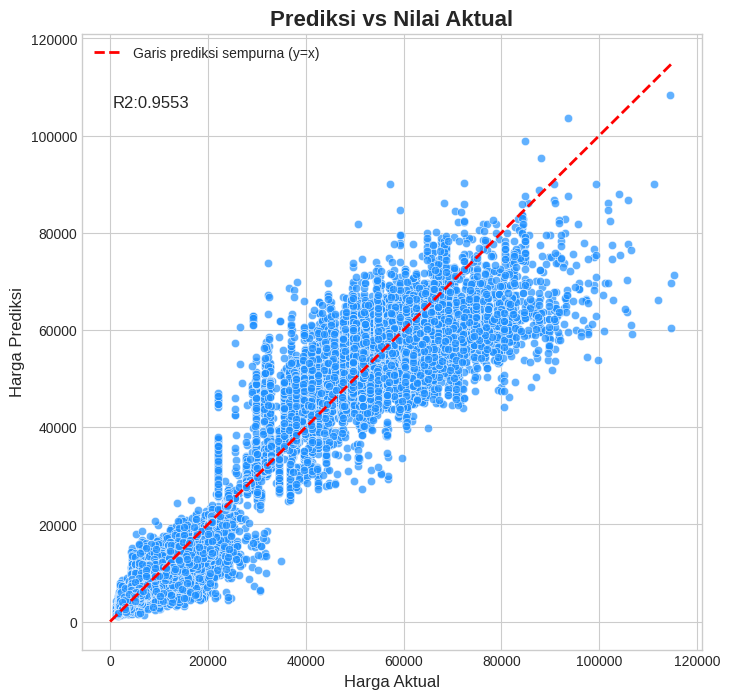

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

seaborn_version = 'seaborn-v0_8-whitegrid'

plt.figure(figsize=(8,8))
plt.style.use(seaborn_version)

sns.scatterplot(x=y_test, y=y_pred, color = 'dodgerblue', alpha=0.7)
max_val = max(y_test.max(), y_pred.max())
y_pred.max()

plt.plot([0, max_val],[0, max_val], 'r--', lw=2, label='Garis prediksi sempurna (y=x)')
plt.title('Prediksi vs Nilai Aktual', fontsize=16, fontweight='bold')
plt.xlabel('Harga Aktual', fontsize=12)
plt.ylabel('Harga Prediksi', fontsize=12)
plt.legend()
plt.text(0.05,0.9, f'R2:{R2:.4f}', transform=plt.gca(). transAxes, fontsize=12, verticalalignment='top')
plt.show()

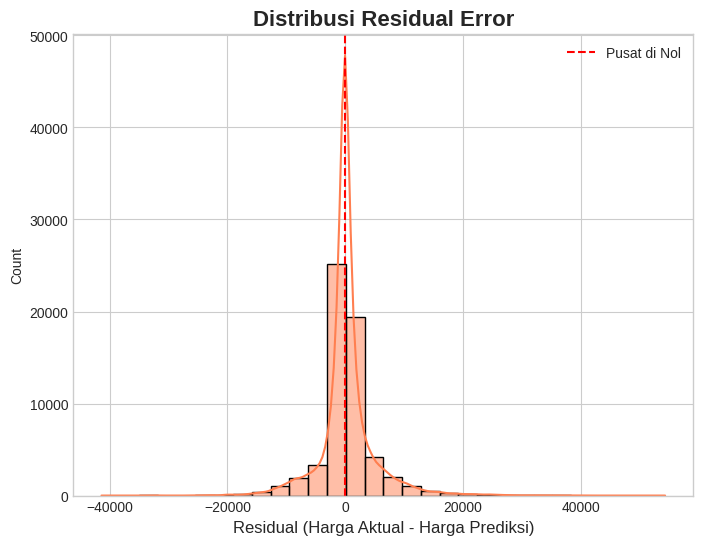

In [34]:
residual = y_test - y_pred

plt.figure(figsize=(8,6))
plt.style.use(seaborn_version)

sns.histplot(residual, kde=True, color='coral', bins=30)
plt.title('Distribusi Residual Error', fontsize=16, fontweight='bold')
plt.xlabel('Residual (Harga Aktual - Harga Prediksi)', fontsize=12)
plt.axvline(0, color='r', linestyle='--', label='Pusat di Nol')
plt.legend()
plt.show()

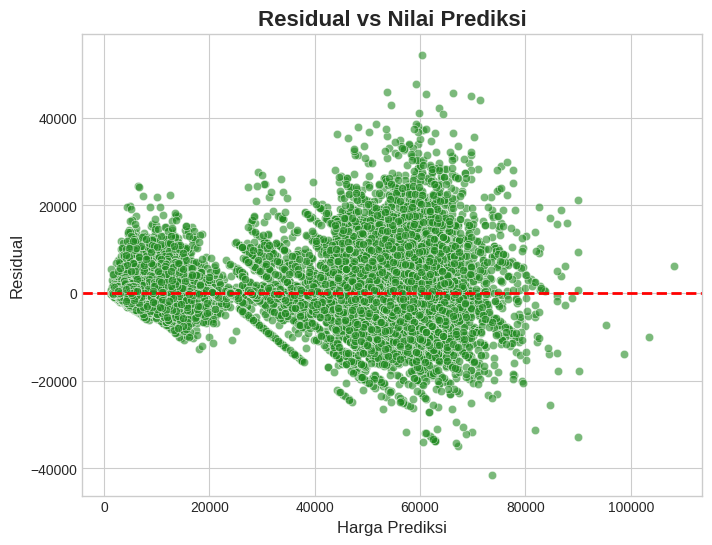

In [35]:
plt.figure(figsize=(8,6))
plt.style.use(seaborn_version)

sns.scatterplot(x=y_pred, y=residual, color='forestgreen', alpha=0.6)
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.title('Residual vs Nilai Prediksi', fontsize=16, fontweight='bold')
plt.xlabel('Harga Prediksi', fontsize=12)
plt.ylabel('Residual', fontsize=12)
plt.show()


In [37]:
# Mengambil step preprocessor dan regressor Catboost

preprocessor = best_cbm.named_steps['preprocessor']
model = best_cbm.named_steps['regressor'].regressor_

In [38]:
# Ambil fitur numerik
num_features = preprocessor.transformers_[0][2]

# Ambil fitur ordinal
ord_features = preprocessor.transformers_[1][2]

# Ambil fitur kategori (one-hot)
ohe = preprocessor.transformers_[2][1]
cat_features = preprocessor.transformers_[2][2]
ohe_features = list(ohe.get_feature_names_out(cat_features))


# Gabungkan semuanya
all_features = list(num_features) + list(ord_features) + ohe_features


In [39]:
# Feature importance dari model XGBoost
importances = model.feature_importances_

# Buat dataframe
feature_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)


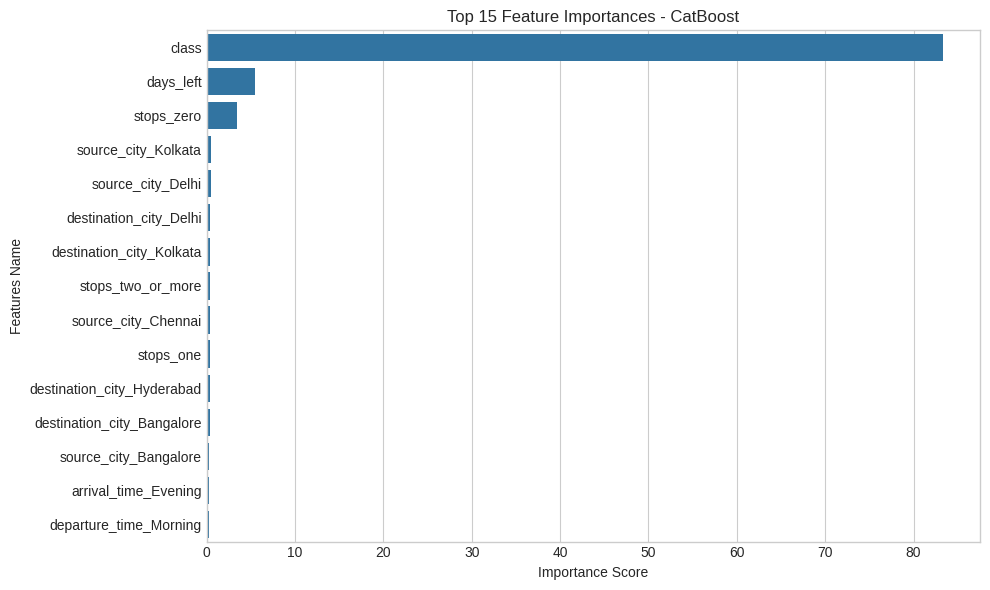

In [40]:
plt.figure(figsize=(10,6))
sns.barplot(data=feature_importance_df.head(15), x='Importance', y='Feature')
plt.title('Top 15 Feature Importances - CatBoost')
plt.xlabel('Importance Score')
plt.ylabel('Features Name')
plt.tight_layout()
plt.show()

In [41]:
import joblib
from google.colab import files

joblib.dump (best_cbm, "CatBoost_Prediction_Flight_Ticket.pkl")
files.download("CatBoost_Prediction_Flight_Ticket.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>